<a href="https://colab.research.google.com/github/prosvirinKir/rzd/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyreadr

     |████████████████████████████████| 419kB 7.6MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid", font_scale=1.4)
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
from tqdm import trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
import pyreadr
from tqdm.notebook import tqdm, trange

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [11]:
df = pyreadr.read_r("/content/gdrive/MyDrive/DLS/hw_segmentation/GOR.rds")

In [12]:
df = df[None]
df = df.loc[:, (df != df.iloc[0]).any()] 
df = df.drop(df[df.TARGET_2 < 0].index)
pd.set_option("display.max_columns", 200)
df = df.drop(["KODOTS", "RASHIFROVKA", "PROVERENO", "PLUS", "STATUS", "CATEGORY", "KODNAPR", "UPDATTR", "TARGET_1", "TARGET_3"], axis=1)
df["AVG_BALL"] = df["AVG_BALL"].str.replace(',', '.')
df["AVG_KILO"] = df["AVG_KILO"].str.replace(',', '.')
df = df.drop(["LINE"], axis=1)
df = df.drop(['X2179_3', 'X2179_4', 'X2195_3', 'X2195_4', 'X2221_4'], axis = 1)

In [13]:
# df_saved = df.copy()

In [20]:
# df = df_saved.copy()

In [22]:
# Normalization

target = df['TARGET_2']
df_columns = df.columns

min_max_scaler = preprocessing.MinMaxScaler()
df.loc[:, :] = min_max_scaler.fit_transform(df)
df['TARGET_2'] = target.values


In [25]:
df['TARGET_2'].unique()

array([0, 1], dtype=int32)

In [27]:
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)

In [28]:
KM_unique = sorted(df.KM.unique())

In [29]:
df = df.sort_values(["KM", "YEAR", "MONTH", "DAY"])
df = df.drop(['YEAR', 'DAY'], axis=1)

In [30]:
small_df = df[['KM', 
               'TARGET_2', 
               'OTS2', 
               'MONTH', 
               'REPAIR_1', 
               'REPAIR_2', 
              #  'DAY', 
               'PRO2', 
               'LENGTH_KILO', 
               'SPEED_NORM_PAS', 
               'SPEED_NORM_PAS_O', 
               'X2161_2', 
               'X2145_2', 
               'SPEED_NORM_FRE', 
               'BALL', 
               'STRELKA']]

In [31]:
data_frame = df # TODO
len(list(data_frame))

142

In [32]:
HISTORY_SIZE = 20
train = torch.zeros((1, HISTORY_SIZE, data_frame.shape[1]))
label = torch.zeros((1))

In [33]:
for km in tqdm(KM_unique):
    df_km = data_frame[data_frame['KM'] == km]
    y_km = df_km['TARGET_2'].values # не сдвинутые 
    df_km['TARGET_2'] = np.hstack((0, y_km[:-1]))
    
    cur_km = 0
    max_iter = df_km.shape[0]
    
    while max_iter >= cur_km + HISTORY_SIZE:

        train_km = df_km.iloc[cur_km:cur_km + HISTORY_SIZE].to_numpy(dtype=np.float16)
        train_km = torch.FloatTensor(train_km)
        train = torch.vstack((train, train_km.unsqueeze(0)))
        label = torch.vstack((label, torch.tensor(y_km[cur_km + HISTORY_SIZE - 1])))
        cur_km += HISTORY_SIZE

In [34]:
# torch.save(train, f'train_{HISTORY_SIZE}.pt')
# torch.save(label, f'label_{HISTORY_SIZE}.pt')

In [35]:
X = train # torch.load('/content/gdrive/MyDrive/DLS/hw_segmentation/train_5.pt')

In [36]:
y = label # torch.load('/content/gdrive/MyDrive/DLS/hw_segmentation/label_5.pt')

In [37]:
y = y.long()

In [38]:
y.dtype

torch.int64

In [39]:
n_samples = X.shape[0]

In [40]:
data = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=n_samples, shuffle=True)

In [41]:
for X_batch, y_batch in data:
  X_shuffle = X_batch
  y_shuffle = y_batch
  break

In [42]:
to_blade = int(n_samples * 0.7)

In [43]:
n_samples, to_blade

(4598, 3218)

In [44]:
# X_train = torch.utils.data.DataLoader(X[:to_blade], batch_size=32) #to shuffle
# X_test = torch.utils.data.DataLoader(X[to_blade:], batch_size=32)

# y_train = torch.utils.data.DataLoader(y[:to_blade], batch_size=32)
# y_test = torch.utils.data.DataLoader(y[to_blade:], batch_size=32)

In [45]:
train_dl = torch.utils.data.DataLoader(list(zip(X_shuffle[:to_blade], y_shuffle[:to_blade])), batch_size=128)
test_dl = torch.utils.data.DataLoader(list(zip(X_shuffle[to_blade:], y_shuffle[to_blade:])), batch_size=128)

In [46]:
for x, y in test_dl:
  print(x.shape, y.shape)
  break

torch.Size([128, 20, 142]) torch.Size([128, 1])


In [47]:
def training(model, criterion, optimizer, num_epochs, train_dl, test_dl, max_grad_norm=2):
    val_losses = []

    for e in trange(num_epochs, leave=False):
        model.train()
        num_iter = 0
        pbar = tqdm(train_dl, leave=False)
        for X_batch, y_batch in pbar:
            optimizer.zero_grad()
            input_embeds = X_batch.to(device)
            # print('input_embeds.shape =', input_embeds.shape)
            # print('input_embeds[0].shape =', input_embeds[0].shape)
            # print('input_embeds[0] =', input_embeds[0])
            labels = y_batch.to(device).flatten()
            # print(labels.flatten())
            # print('labels.shape =', labels.shape)
            # print('labels[0] =', labels[0])
            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        valid_loss = 0
        valid_acc = 0
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for X_batch, y_batch in test_dl:
                input_embeds = X_batch.to(device)
                labels = y_batch.to(device).flatten()
                prediction = model(input_embeds)
                valid_loss += criterion(prediction, labels)
                correct += (labels == prediction.argmax(-1)).float().sum()
                num_objs += len(labels)
                num_iter += 1
        val_losses.append(valid_loss / num_iter)
        #print(f"Valid Loss: {valid_loss / num_iter}, accuracy: {correct/num_objs}")
    return val_losses

In [48]:
class GRU(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super().__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.w_rh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_rh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_rx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_rx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_zh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_zh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_zx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_zx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_nh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_nh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_nx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_nx = nn.Parameter(torch.rand(1, hidden_size))

    def forward(self, x, hidden = None):
        '''
        x – torch.FloatTensor with the shape (bs, seq_length, emb_size)
        hidden - torch.FloatTensro with the shape (bs, hidden_size)
        return: torch.FloatTensor with the shape (bs, hidden_size)
        '''
        if hidden is None:
            hidden = torch.zeros((x.size(0), self.hidden_size)).to(x.device)
        
        for cur_idx in range(x.size(1)):
            r = torch.sigmoid(
                x[:, cur_idx] @ self.w_rx + self.b_rx + hidden @ self.w_rh + self.b_rh
            )
            z = torch.sigmoid(
                x[:, cur_idx] @ self.w_zx + self.b_zx + hidden @ self.w_zh + self.b_zh
            )
            n = torch.tanh(
                x[:, cur_idx] @ self.w_nx + self.b_nx + r * (hidden @ self.w_nh + self.b_nh)
            )
            hidden = (1 - z) * n + z * hidden

        return hidden

In [49]:
class GRUModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=2):
        super().__init__()
        self.gru = GRU(embed_size, hidden_size)
        self.cls = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        hidden = self.gru(x)
        hidden = self.cls(hidden)
        hidden = self.softmax(hidden)
        return hidden

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [51]:
len(list(data_frame))

142

In [67]:
num_features = len(list(data_frame))
n_hidden = len(list(data_frame))
model = GRUModel(num_features, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 40
max_grad_norm = 1.0

In [68]:
val_losses = training(model, criterion, optimizer, num_epochs, train_dl, test_dl, max_grad_norm)

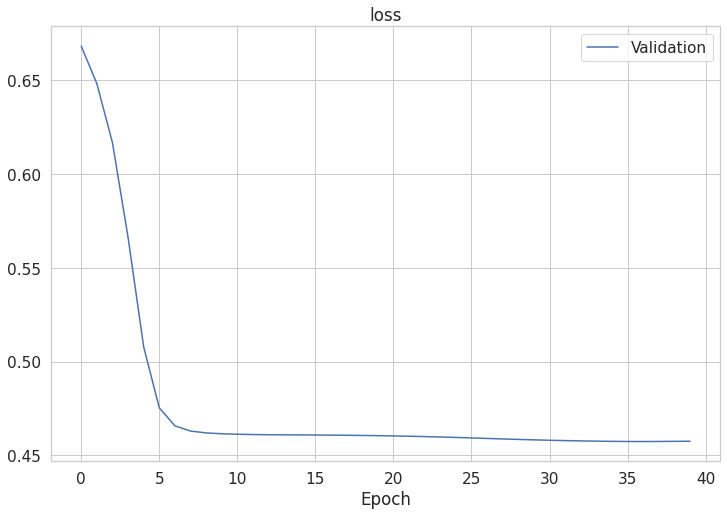

In [71]:
plt.figure(figsize=(12, 8))
# plt.plot(np.arange(len(train_losses) - 1), train_losses[1:], label='Train')
plt.plot(np.arange(len(val_losses) ), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

In [72]:
val_losses

[tensor(0.6683, device='cuda:0'),
 tensor(0.6483, device='cuda:0'),
 tensor(0.6168, device='cuda:0'),
 tensor(0.5662, device='cuda:0'),
 tensor(0.5079, device='cuda:0'),
 tensor(0.4754, device='cuda:0'),
 tensor(0.4658, device='cuda:0'),
 tensor(0.4630, device='cuda:0'),
 tensor(0.4620, device='cuda:0'),
 tensor(0.4615, device='cuda:0'),
 tensor(0.4613, device='cuda:0'),
 tensor(0.4611, device='cuda:0'),
 tensor(0.4610, device='cuda:0'),
 tensor(0.4610, device='cuda:0'),
 tensor(0.4609, device='cuda:0'),
 tensor(0.4609, device='cuda:0'),
 tensor(0.4608, device='cuda:0'),
 tensor(0.4607, device='cuda:0'),
 tensor(0.4606, device='cuda:0'),
 tensor(0.4605, device='cuda:0'),
 tensor(0.4604, device='cuda:0'),
 tensor(0.4602, device='cuda:0'),
 tensor(0.4600, device='cuda:0'),
 tensor(0.4598, device='cuda:0'),
 tensor(0.4596, device='cuda:0'),
 tensor(0.4593, device='cuda:0'),
 tensor(0.4590, device='cuda:0'),
 tensor(0.4588, device='cuda:0'),
 tensor(0.4585, device='cuda:0'),
 tensor(0.4583

In [73]:
test_dl = torch.utils.data.DataLoader(list(zip(X_shuffle[to_blade:], y_shuffle[to_blade:])), batch_size=n_samples-to_blade)

In [74]:
for X_batch, y_batch in test_dl:
  preds = model(X_batch.to(device))
  break

In [75]:
preds = preds.detach().cpu().numpy()

In [76]:
preds.shape, preds[:20]

((1380, 2), array([[9.9986076e-01, 1.3920933e-04],
        [7.4164587e-01, 2.5835416e-01],
        [9.9969029e-01, 3.0976828e-04],
        [9.9983811e-01, 1.6181465e-04],
        [9.9991870e-01, 8.1248312e-05],
        [9.9987674e-01, 1.2324312e-04],
        [9.9982738e-01, 1.7261236e-04],
        [9.9988294e-01, 1.1699852e-04],
        [9.9996448e-01, 3.5465866e-05],
        [9.9992287e-01, 7.7119767e-05],
        [9.9997663e-01, 2.3414575e-05],
        [8.6888844e-01, 1.3111156e-01],
        [8.1664032e-01, 1.8335967e-01],
        [9.9993610e-01, 6.3874628e-05],
        [9.1187429e-01, 8.8125728e-02],
        [9.9987972e-01, 1.2023262e-04],
        [9.9989903e-01, 1.0100465e-04],
        [9.9981087e-01, 1.8915441e-04],
        [9.9992371e-01, 7.6267897e-05],
        [9.9990189e-01, 9.8143573e-05]], dtype=float32))

In [77]:
test_auc = roc_auc_score(y_batch, preds[:,1])
test_auc

0.6813058556756035

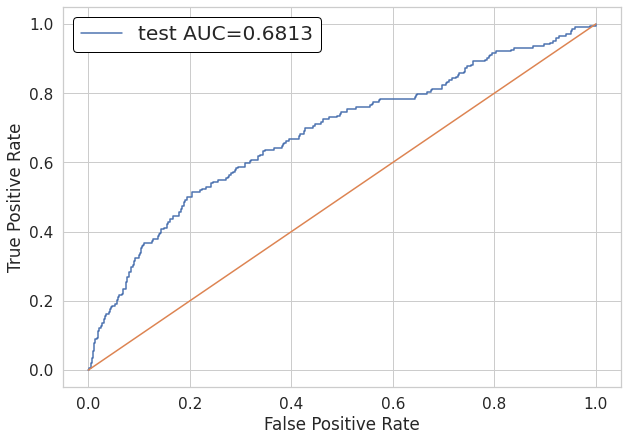

In [78]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_batch, preds[:,1])[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
# plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [61]:
col2idx['TARGET_2']

NameError: ignored

In [ ]:
to_norm = ['delta_OTS_2',
           'delta_OTS_3',
           'delta_OTS_4',
           'delta_O_1',
           'delta_O_2',	
           'delta_O_3',	
           'delta_O_4',	
           'delta_O_T',
           'YEAR', 'MONTH',	'DAY',	
           'KM',	
           'M',	
           'BALL',	
           'SPEED_RES_PAS',	
           'SPEED_RES_FRE',	
           'SPEED_RES_EMPTY',	
           'SPEED_NORM_PAS',	
           'SPEED_NORM_FRE',	
           'LENGTH_KILO',
           'PCH',
           'BALL',
           'RIX2',
           'RIX3',
           'RIX4',
           'USH2',
           'USH3',
           'USH4',
           'SUG2',
           'SUG3',
           'SUG4',
           'PLU2',
           'PLU3',
           'PLU4',
           'PER2',
           'PER3',
           'PER4',
           'PRO2',
           'PRO3',
           'PRO4',
           'OTS2',
           'OTS3',
           'OTS4',
           'UKL',
           'DRU',
           'AVG_BALL',
           'AVG_KILO',
           'X2049_3',
           ]

In [62]:
for idx, col in enumerate(list(df)):
    print(f'{idx}: COLUMN={col}\n{df[col].unique()}\n')

0: COLUMN=PCH
[0.12765957 0.15957447 0.19148936 0.14893617 0.09574468 0.25531915
 0.05319149 0.96808511 0.9893617  1.         0.23404255 0.10638298
 0.03191489 0.13829787 0.21276596 0.         0.22340426 0.30851064
 0.07446809 0.24468085 0.0212766  0.9787234  0.04255319 0.29787234
 0.18085106 0.17021277 0.08510638 0.26595745 0.27659574]

1: COLUMN=MONTH
[0.         0.09090909 0.18181818 0.45454545 0.81818182 0.90909091
 0.36363636 0.27272727 0.54545455 0.63636364 0.72727273 1.        ]

2: COLUMN=KM
[0.00000000e+00 6.36942675e-04 1.27388535e-03 ... 9.98726115e-01
 9.99363057e-01 1.00000000e+00]

3: COLUMN=M
[6.37764933e-01 6.38407193e-01 6.39049454e-01 6.39691715e-01
 6.40333976e-01 6.41618497e-01 0.00000000e+00 3.17276814e-01
 2.29287091e-01 6.40976236e-01 2.55619782e-01 2.56904303e-01
 2.25433526e-01 3.27552987e-02 2.85806037e-01 2.77456647e-01
 2.87732820e-01 2.85163776e-01 2.90301863e-01 2.66538215e-01
 2.87090559e-01 2.89017341e-01 2.91586384e-01 6.37122672e-01
 2.86448298e-01 2.6